# Beyond SIR modeling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/collectif-codata/pyepidemics/blob/master/docs/tutorials/beyond-sir.ipynb)

<div class="admonition note">
<p class="admonition-title">Note</p>
<p>
In this tutorial we will see how we can build differential equations models and go from simple SIR modeling to add more states and model public policies such as lockdown
</p>
</div>

##### Developer import

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Developer import
import sys
sys.path.append("../../")

##### On Google Colab
Uncomment the following line to install the library locally

In [2]:
# !pip install pyepidemics

##### Verify the library is correctly installed

In [4]:
import pyepidemics
from pyepidemics.models import SIR,SEIR,SEIDR,SEIHDR

# Introduction 

<div class="admonition tip">
<p class="admonition-title">Tip</p>
<p>
This tutorial is largely inspired from this great article [Infectious Disease Modelling: Beyond the Basic SIR Model](https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4) by Henri Froese, from which actually a huge part of the code from this library is inspired. 
</div>

# Simple models by complexity

## SIR model

Differential equations models represents transitions between population states. <br>
SIR is one the most simple model used for many epidemics, in which you suppose three population states : 
    
- ``S`` - Susceptible state, all people that can still be infected
- ``I`` - Infected state, contaminated people that will recover
- ``R`` - Removed state, people that are removed from the models, ie that cannot be infected again which is either you recover and you are immune, or unfortunately you are deceased

Between each state you consider three information : 
- The **population** considered
- The temporal **rate** (ie 1/duration) representing the number of persons transitioning per day
- The **probability** to go to the next state

You can also notice the **epidemiological parameters** such as $\beta$ or $\gamma$

![](https://miro.medium.com/max/1400/1*NNO-CdlCZORoPYtllW343A.png)

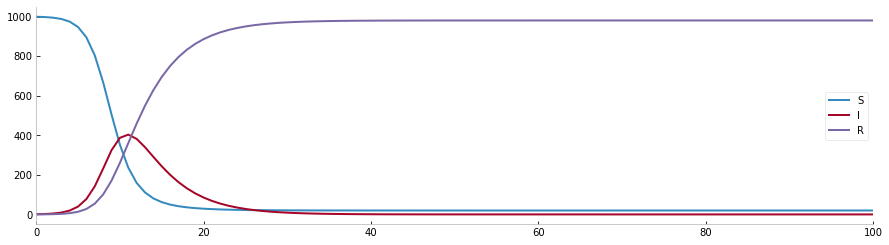

In [5]:
N = 1000
beta = 1
gamma = 1/4

# Define model
sir = SIR(N,beta,gamma)

# Solve the equations
states = sir.solve(init_state = 1)
states.show(plotly = False)

You can visualize the transitions by compartments, with the command ``.network.show()`` (which is not super useful for SIR models, but can be interesting to check more complex models)

[INFO] Displaying only the largest graph component, graphs may be repeated for each category


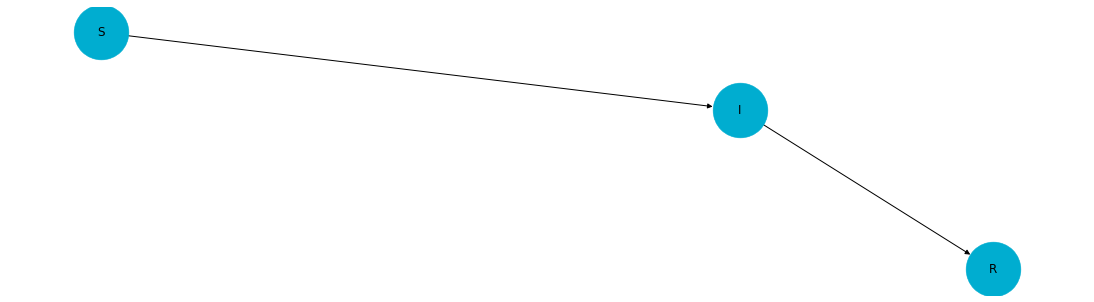

In [17]:
sir.network.show()

## SEIR model

![](https://miro.medium.com/max/1400/1*B-HZLpVWEgAZ3iloHBJjCA.png)

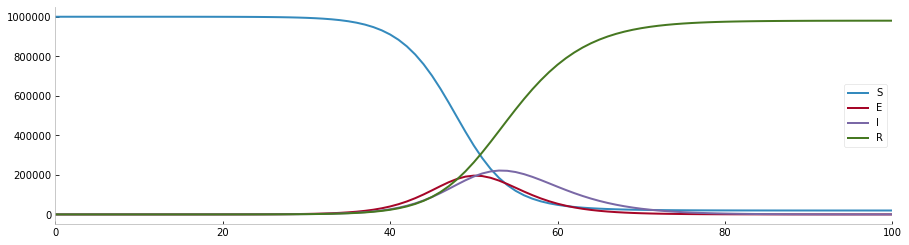

In [6]:
# Population 
N = 1e6
beta = 1
delta = 1/3
gamma = 1/4

# Define the model
seir = SEIR(N,beta,delta,gamma)

# Solve the equations
states = seir.solve(init_state = 1)
states.show(plotly = False)

[INFO] Displaying only the largest graph component, graphs may be repeated for each category


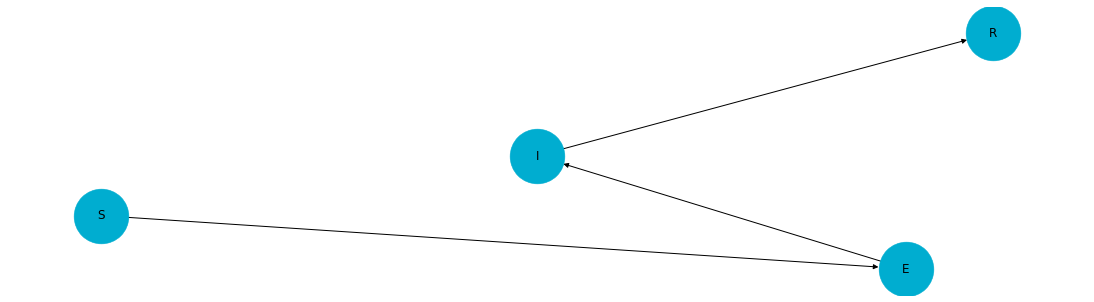

In [15]:
seir.network.show()

## SEIDR model

![](https://miro.medium.com/max/1400/1*TIZaRpt70TR1RFtf2dmlew.png)

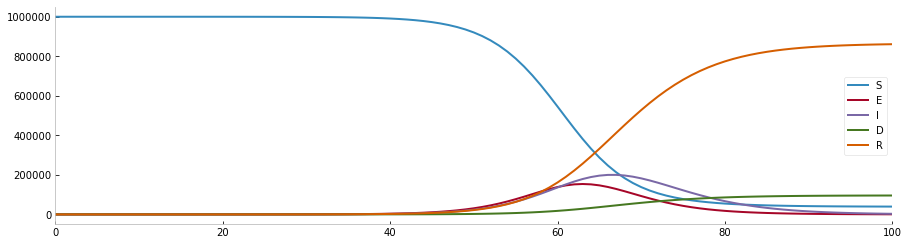

In [7]:
# Population 
N = 1e6
gamma = 1/4
beta = 3/4
delta = 1/3
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death 

# Define the model
seidr = SEIDR(N,beta,delta,gamma,rho,alpha)

# Solve the equations
states = seidr.solve(init_state = 1)
states.show(plotly = False)

[INFO] Displaying only the largest graph component, graphs may be repeated for each category


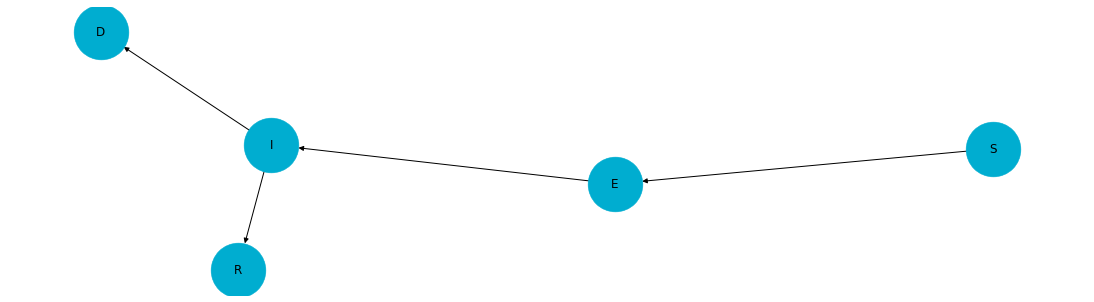

In [13]:
seidr.network.show()

## SEIHDR model

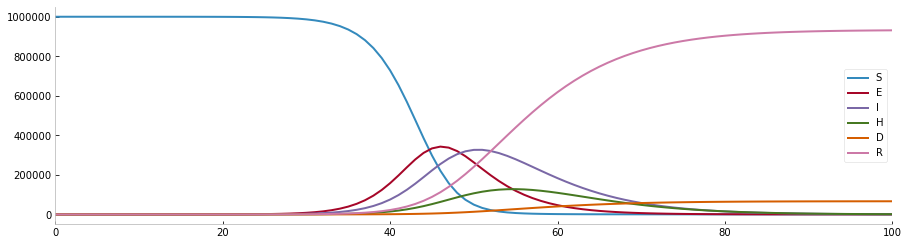

In [8]:
# Population 
N = 1e6
beta = 1/4 * 5 # R0 = 2.5
delta = 1/5
gamma = 1/4
theta = 1/5 # ndays before complication
kappa = 1/10 # ndays before symptoms disappear
phi = 0.5 # probability of complications
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death 

# Define the model
seihdr = SEIHDR(N,beta,delta,gamma,rho,alpha,theta,phi,kappa)

# Solve the equations
states = seihdr.solve(init_state = 1,n_days = 100)
states.show(plotly = False)

[INFO] Displaying only the largest graph component, graphs may be repeated for each category


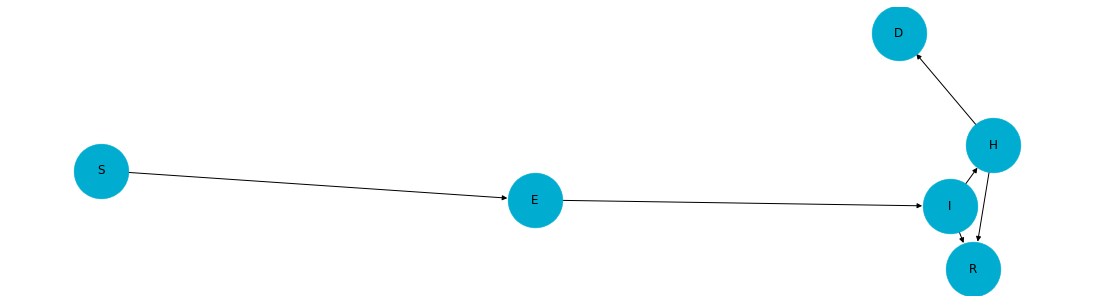

In [10]:
seihdr.network.show()

## Towards COVID19 modeling

To model COVID19 epidemics, we can use a more complex compartmental model to account for different levels of symptoms and patients going to ICU. You can read more about it in this [tutorial](https://collectif-codata.github.io/pyepidemics/tutorials/covid/)

# Modeling policies

## Simulating parameters change over time

To model any policy with macro-epidemiological models we can play with the parameters or the equations. One simple way to model the implementation of a public policy is to make one parameter vary over time when it's implemented. For example to model a lockdown (or any equivalent policy such as social distancing, masks, ...) we can make the parameter ``beta`` vary.

### Piecewise evolution

One option is to take a piecewise function that can be as simple as shown here

In [34]:
date_lockdown = 53

def beta(t):
    if t < date_lockdown:
        return 3.3/4
    else:
        return 1/4

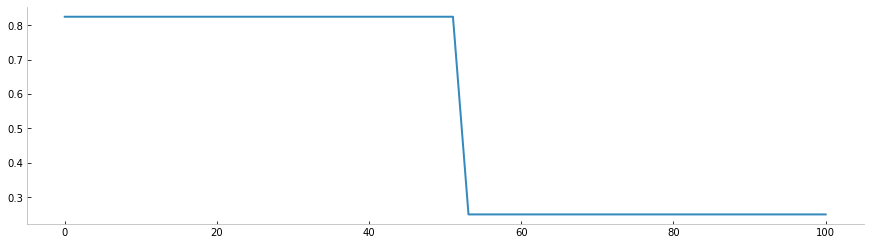

In [38]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,100)
y = np.vectorize(beta)(x)

plt.figure(figsize = (15,4))
plt.plot(x,y);

For convenience we can use the helper function defined in pyepidemics

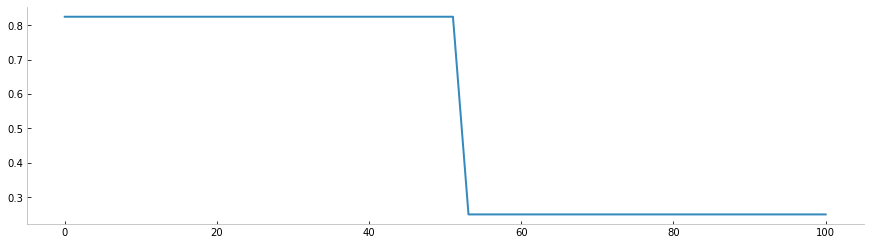

In [99]:
from pyepidemics.policies.utils import make_dynamic_fn

policies = [
    3.3/4,
    (1/4,53),
]

fn = make_dynamic_fn(policies,sigmoid = False)

# Visualize policies
x = np.linspace(0,100)
y = np.vectorize(fn)(x)
plt.figure(figsize = (15,4))
plt.plot(x,y);

The result is the same, but we can use this function for more complex policies

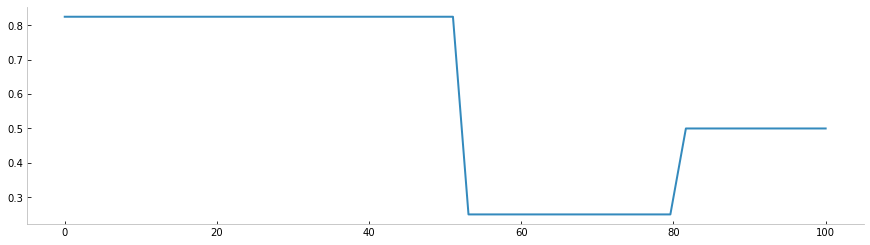

In [100]:
from pyepidemics.policies.utils import make_dynamic_fn

policies = [
    3.3/4,
    (1/4,53),
    (2/4,80),
]

fn = make_dynamic_fn(policies,sigmoid = False)

# Visualize policies
x = np.linspace(0,100)
y = np.vectorize(fn)(x)
plt.figure(figsize = (15,4))
plt.plot(x,y);

### Gradual transitions with sigmoid
Behaviors don't change over a day, to model this phenomenon we could prefer gradual transitions from one value to the next using sigmoid functions. We can use the previous function for that : 

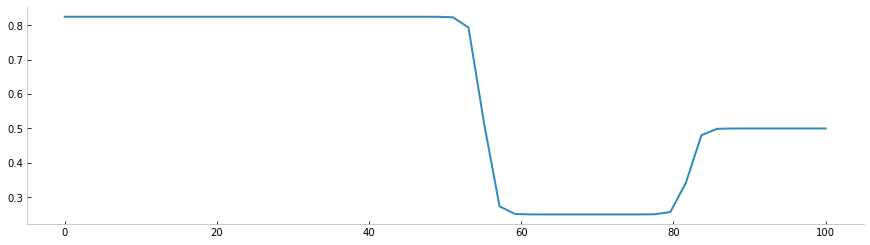

In [101]:
from pyepidemics.policies.utils import make_dynamic_fn

policies = [
    3.3/4,
    (1/4,53),
    (2/4,80),
]

fn = make_dynamic_fn(policies,sigmoid = True)

# Visualize policies
x = np.linspace(0,100)
y = np.vectorize(fn)(x)
plt.figure(figsize = (15,4))
plt.plot(x,y);

We can even specify the transitions durations as followed

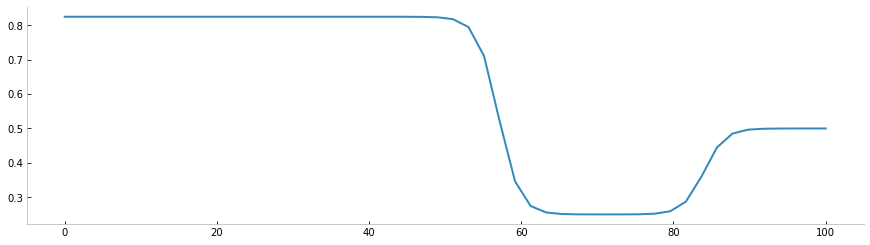

In [104]:
from pyepidemics.policies.utils import make_dynamic_fn

policies = [
    3.3/4,
    (1/4,53),
    (2/4,80),
]

fn = make_dynamic_fn(policies,sigmoid = True,transition = 8)

# Visualize policies
x = np.linspace(0,100)
y = np.vectorize(fn)(x)
plt.figure(figsize = (15,4))
plt.plot(x,y);

Or even for each transition

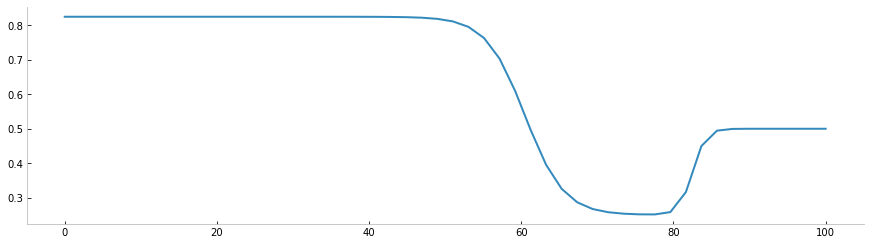

In [108]:
from pyepidemics.policies.utils import make_dynamic_fn

policies = [
    3.3/4,
    (1/4,53,15),
    (2/4,80,5),
]

fn = make_dynamic_fn(policies,sigmoid = True)

# Visualize policies
x = np.linspace(0,100)
y = np.vectorize(fn)(x)
plt.figure(figsize = (15,4))
plt.plot(x,y);

## Lockdown

Instead of passing a constant as beta in the previous SEIHDR model, we can pass any function depending over time

In [116]:
lockdown_date = 53

policies = [
    3.3/4,
    (1/4,lockdown_date),
]

fn = make_dynamic_fn(policies,sigmoid = True)

beta = lambda y,t : fn(t)

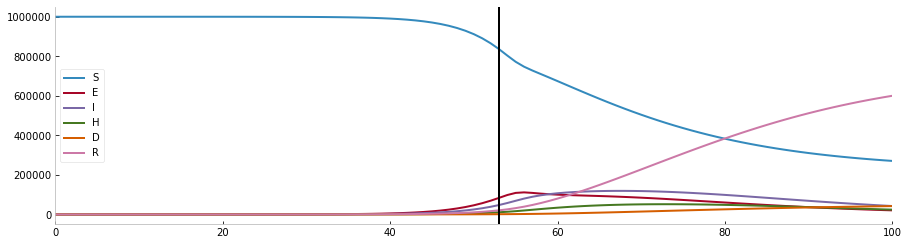

In [117]:
# Population 
N = 1e6
delta = 1/5
gamma = 1/4
theta = 1/5 # ndays before complication
kappa = 1/10 # ndays before symptoms disappear
phi = 0.5 # probability of complications
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death 

# Define the model
seihdr = SEIHDR(N,beta,delta,gamma,rho,alpha,theta,phi,kappa)

# Solve the equations
states = seihdr.solve(init_state = 1,n_days = 100)

# Visualize the epidemic curves
states.show(plotly = False,show = False)
plt.axvline(lockdown_date,c = "black")
plt.show()

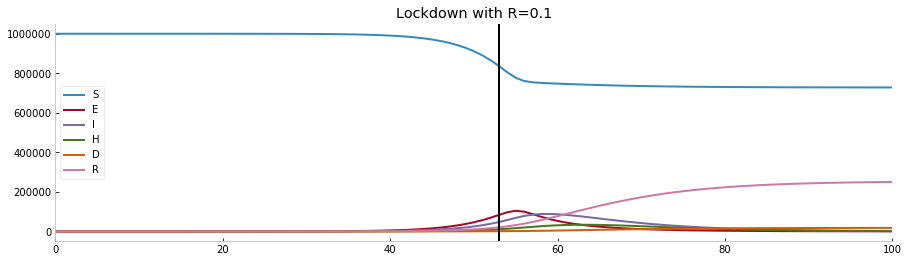

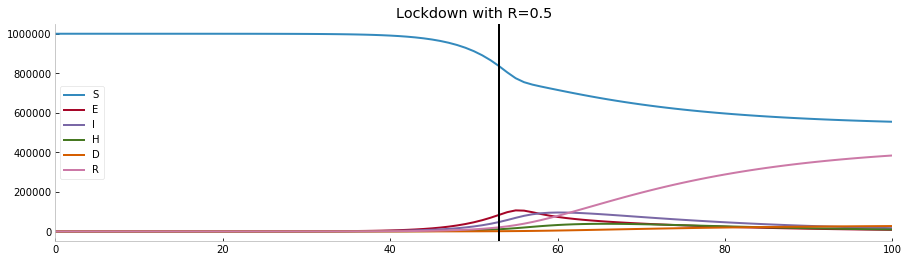

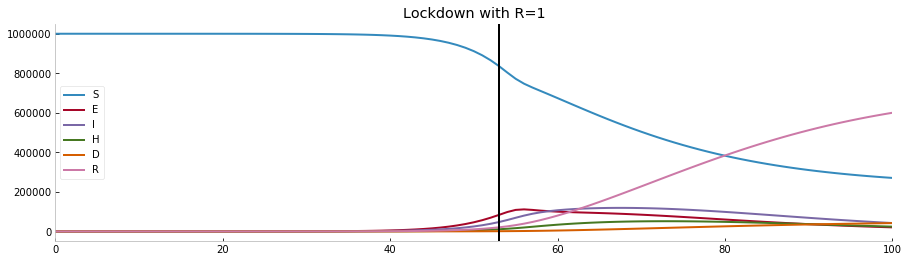

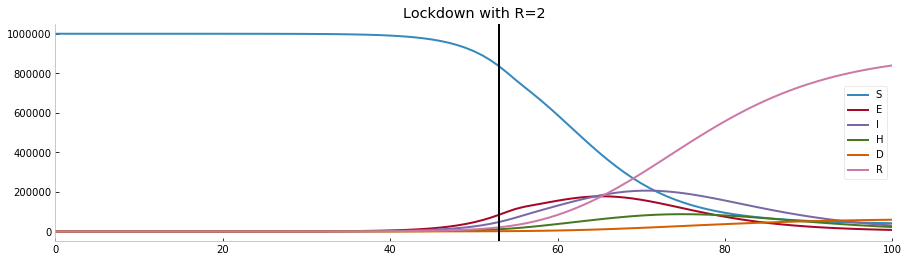

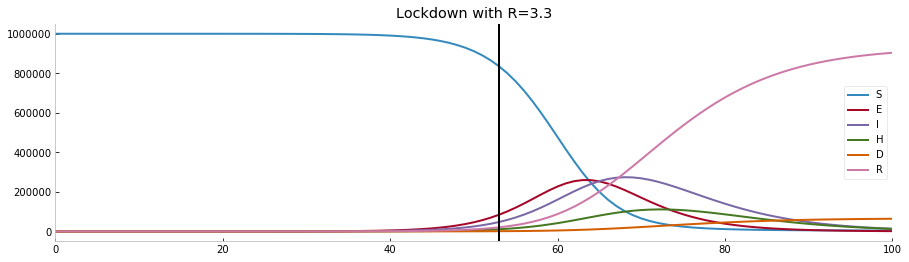

In [119]:
for Rlockdown in [0.1,0.5,1,2,3.3]:
    
    lockdown_date = 53
    policies = [
        3.3/4,
        (Rlockdown/4,lockdown_date),
    ]

    fn = make_dynamic_fn(policies,sigmoid = True)
    beta = lambda y,t : fn(t)
    
    
    # Define the model
    seihdr = SEIHDR(N,beta,delta,gamma,rho,alpha,theta,phi,kappa)
    states = seihdr.solve(init_state = 1,n_days = 100)

    # Visualize the epidemic curves
    states.show(plotly = False,show = False)
    plt.axvline(lockdown_date,c = "black")
    plt.title(f"Lockdown with R={Rlockdown}")
    plt.show()

## Lockdown exit

Now that you've understood how to change a parameter over time, it's easy to simulate a lockdown exit by adding a new parameter. 

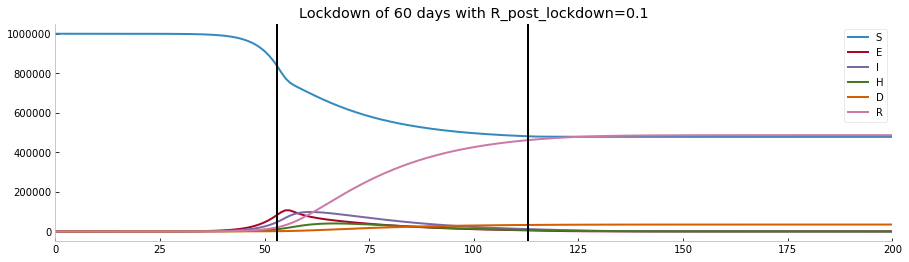

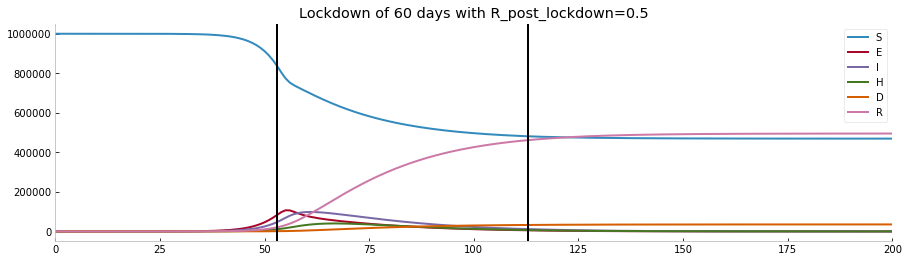

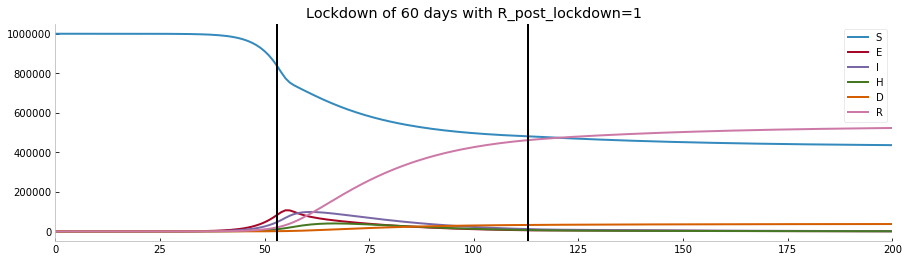

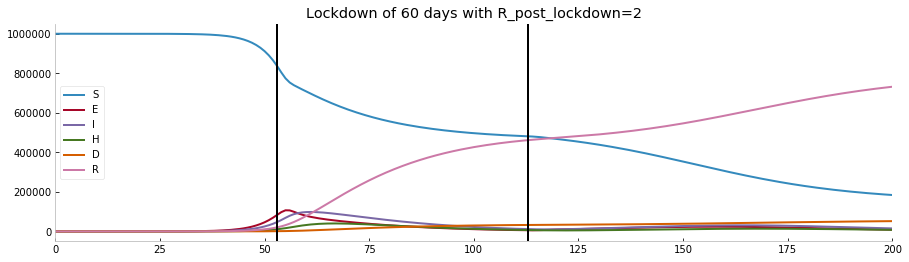

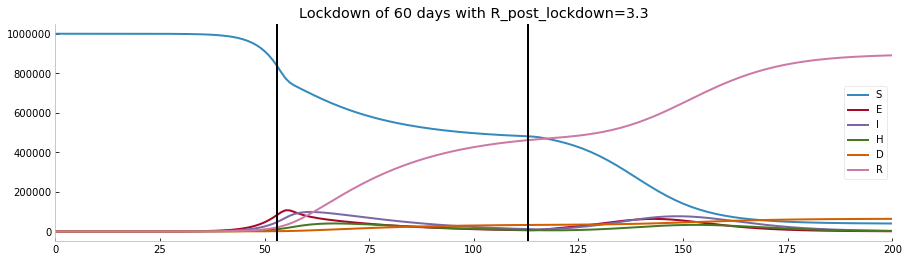

In [121]:
for R_post_lockdown in [0.1,0.5,1,2,3.3]:
    
    lockdown_date = 53
    duration_lockdown = 60
    
    policies = [
        3.3/4,
        (0.6/4,lockdown_date),
        (R_post_lockdown/4,lockdown_date+duration_lockdown),

    ]

    fn = make_dynamic_fn(policies,sigmoid = True)
    beta = lambda y,t : fn(t)
    
    
    # Define the model
    seihdr = SEIHDR(N,beta,delta,gamma,rho,alpha,theta,phi,kappa)
    states = seihdr.solve(init_state = 1,n_days = 200)

    # Visualize the epidemic curves
    states.show(plotly = False,show = False)
    plt.axvline(lockdown_date,c = "black")
    plt.axvline(lockdown_date+duration_lockdown,c = "black")
    plt.title(f"Lockdown of {duration_lockdown} days with R_post_lockdown={R_post_lockdown}")
    plt.show()

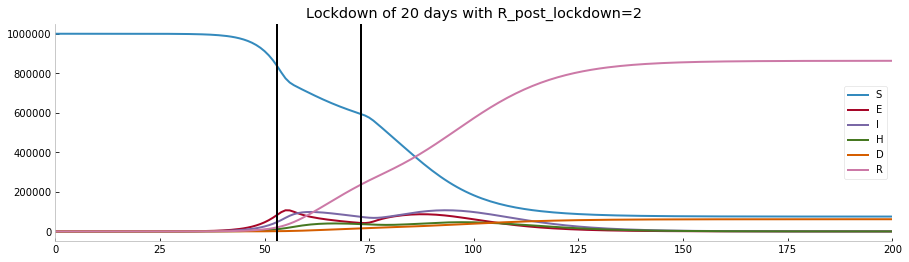

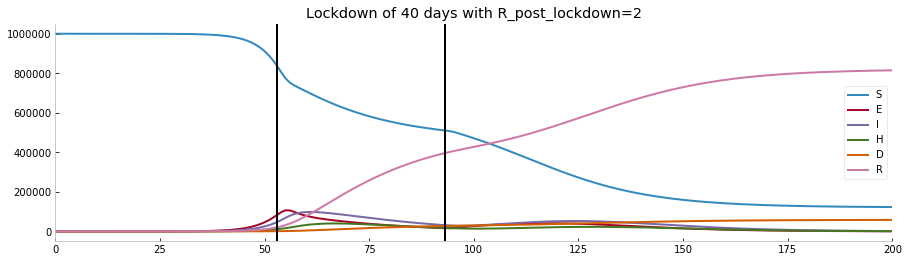

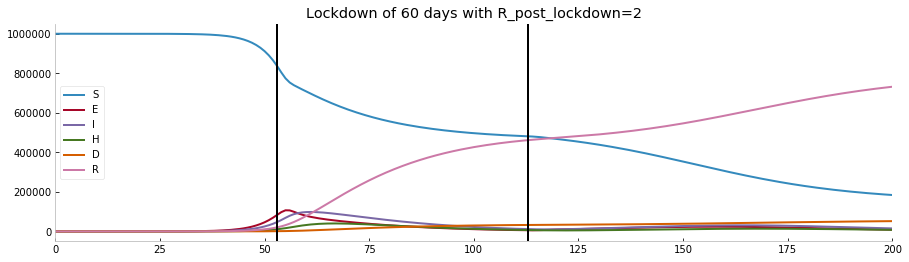

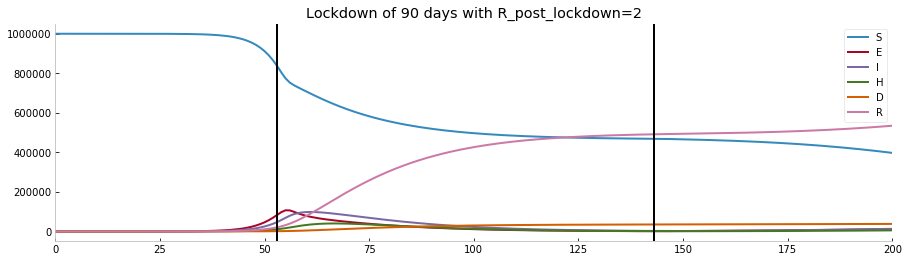

In [122]:
for duration_lockdown in [20,40,60,90]:
    
    lockdown_date = 53
    R_post_lockdown = 2
    
    policies = [
        3.3/4,
        (0.6/4,lockdown_date),
        (R_post_lockdown/4,lockdown_date+duration_lockdown),

    ]

    fn = make_dynamic_fn(policies,sigmoid = True)
    beta = lambda y,t : fn(t)
    
    
    # Define the model
    seihdr = SEIHDR(N,beta,delta,gamma,rho,alpha,theta,phi,kappa)
    states = seihdr.solve(init_state = 1,n_days = 200)

    # Visualize the epidemic curves
    states.show(plotly = False,show = False)
    plt.axvline(lockdown_date,c = "black")
    plt.axvline(lockdown_date+duration_lockdown,c = "black")
    plt.title(f"Lockdown of {duration_lockdown} days with R_post_lockdown={R_post_lockdown}")
    plt.show()

## Note on epidemiological parameters

Parameters such as beta, R0, or probabilities between states are the main component in differential equations models. You have a few methods to evaluate them: 

- Either you estimate the parameters on real-data, this is called **calibration**, you can read more in this [tutorial](https://collectif-codata.github.io/pyepidemics/tutorials/calibration/)
- Some of them are already pretty well estimated by researchers, like $R0$

Here in this example the lockdown is simulated by varying the beta, but actually beta encompass individual behavior change, social distancing, self isolation, masks, etc... To better estimate scenarios other options are available from using contact matrices to switching to individual-center models (agent based modeling). 